# Vehicle Detection Testing and Exploring

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from random import random
from collections import deque
import glob
import pickle
import time
%matplotlib inline

### Dataset retrieval and exploration functions

In [2]:
# Get list of images given a regular expression
def retrieveImagePathList(folder_regx):
    path_list = []
    for i in glob.glob(folder_regx, recursive=True):
        path_list.append(i)
    return path_list

# Prints out general info on the dataset
def exploreDataset(car_glob, not_car_glob):
    dataset_dict = {}
    dataset_dict["car_count"] = len(car_glob)
    dataset_dict["not_car_count"] = len(not_car_glob)
    sample_car_image = cv2.imread(car_glob[int(random() * dataset_dict["car_count"])])
    sample_not_car_image = cv2.imread(not_car_glob[int(random() * dataset_dict["not_car_count"])])

    dataset_dict["car_img_shape"]  = sample_car_image.shape
    dataset_dict["car_img_type"]  = sample_not_car_image.dtype

    dataset_dict["not_car_img_shape"]  = sample_car_image.shape
    dataset_dict["not_car_img_type"]  = sample_not_car_image.dtype
    return dataset_dict

# Retrieve the dataset and view some basic info on it
def get_dataset():
    car = retrieveImagePathList('dataset/vehicles/**/*.png')
    notCar = retrieveImagePathList('dataset/non-vehicles/**/*.png')
    dataInfo = exploreDataset(car,notCar)
    print("The datset has these parameters: ")
    print("Number of car images\t\t", dataInfo["car_count"])
    print("Number of not car images\t", dataInfo["not_car_count"])
    print("Shape of the car images\t\t", dataInfo["car_img_shape"])
    print("Datatype of the car images\t", dataInfo["car_img_type"])
    print("Shape of the not car images\t", dataInfo["not_car_img_shape"])
    print("Datatype of the not car images\t", dataInfo["not_car_img_type"])
    print("Dataset size difference\t\t",
        1-(abs((dataInfo["car_count"]-dataInfo["not_car_count"])/(dataInfo["car_count"]+dataInfo["not_car_count"]))*100),"%" )
    # And show some example images from each
    car_image = cv2.imread(car[int(random() * dataInfo["car_count"])])
    car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.subplot(121)
    plt.title("Vehicle")
    plt.imshow(car_image)
    not_car_image = cv2.imread(notCar[int(random() * dataInfo["not_car_count"])])
    not_car_image = cv2.cvtColor(not_car_image, cv2.COLOR_BGR2RGB)
    plt.subplot(122)
    plt.title("Not a Vehicle")
    plt.imshow(not_car_image)
    return car, notCar, dataInfo

## Global definitions

In [3]:
# Define a color space dict. All image reads done by cv2.imread()
CS = {'HSV':    cv2.COLOR_BGR2HSV,
      'YUV':    cv2.COLOR_BGR2YUV,
      'YCrCb':  cv2.COLOR_BGR2YCrCb,
      'LUV':    cv2.COLOR_BGR2LUV,
      'HLS':    cv2.COLOR_BGR2HLS}
# Declare these globally, so there isn't confusion
# pixels per cell
PPC = 20
# cells per block
CPB = 2
# ORI
ORI = 9
# hist bins
HB = 6
# hist range
HR = (0, 256)
# downsample size
RSIZE = (10, 10)
# color space
CSPACE = "YCrCb"
# Channels to use
CHANS=[1,2,3]

## HOG feature extraction functions

In [4]:
def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hog_by_chan(img, rav=True, vis=False, gaus=5):
    """
    Compute individual channel HOG features for the image
    """
    img = cv2.cvtColor(img, CS[CSPACE]).astype(np.float32)
    ch1 = img[:, :, 0]
    ch2 = img[:, :, 1]
    ch3 = img[:, :, 2]
    if gaus > 0:
        ch1 = gaussian_blur(ch1, gaus)
        ch2 = gaussian_blur(ch2, gaus)
        ch3 = gaussian_blur(ch3, gaus)
    channel = [ch1, ch2, ch3]
    hoglist = []
    imagelist = []
    for ch in CHANS:
        h = hog(channel[ch-1], orientations=ORI, pixels_per_cell=(PPC, PPC),
                cells_per_block=(CPB, CPB), visualise=vis,
                feature_vector=False, block_norm='L2-Hys')
        if not vis:
            hoglist.append(h)
        else:
            hoglist.append(h[0])
            imagelist.append(h[1])
    if rav:
        HOG = np.ravel(hoglist)
        if vis:
            return HOG, imagelist
        return HOG
    elif vis:
        return hoglist, imagelist
    return hoglist


### Spacial and color histogram functions

In [5]:
def bin_spatial(img):
    # Convert image to new color space (if specified)
    if CSPACE != 'BGR':
        image = cv2.cvtColor(img, CS[CSPACE])
    else:
        image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(image, RSIZE).ravel()
    # Return the feature vector
    return features


def color_hist(img):
    # Compute the histogram of the color channels separately
    channel_hist = []
    channel_hist.append(np.histogram(img[:, :, 0], bins=HB))
    channel_hist.append(np.histogram(img[:, :, 1], bins=HB))
    channel_hist.append(np.histogram(img[:, :, 2], bins=HB))
    # Concatenate the histograms into a single feature vector
    channel_hist = [chan[0]
                    for i, chan in enumerate(channel_hist) if i+1 in CHANS]
    hist_features = np.concatenate((channel_hist))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def normalize_features(car_features, not_car_features, X_scaler):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
    # Apply and return the scaler to X
    return X, X_scaler.transform(X)

## Quick dataset exploration

Take a look at how big the dataset is, how many of each vehicle and non-vehicle there is, the type and size of the images, and a sample image of each. 

The datset has these parameters: 
Number of car images		 8792
Number of not car images	 8968
Shape of the car images		 (64, 64, 3)
Datatype of the car images	 uint8
Shape of the not car images	 (64, 64, 3)
Datatype of the not car images	 uint8
Dataset size difference		 0.009009009009009028 %


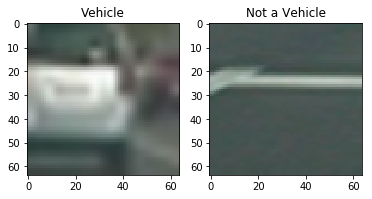

In [6]:
carFiles, notCarFiles, dataInfo = get_dataset()

## Visualize a vehcile and non-vehicle's extracted HOG images 

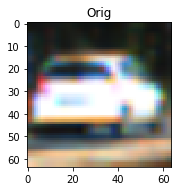

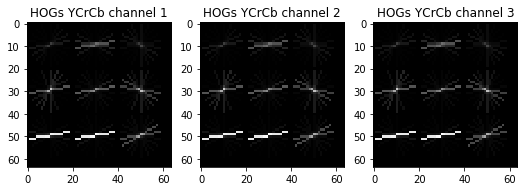

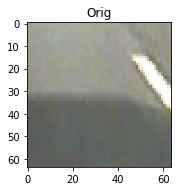

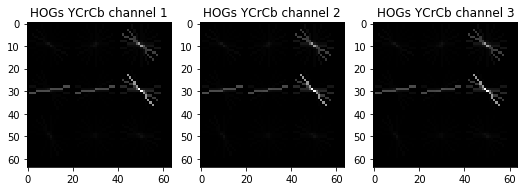

In [7]:
row = 2
col = 5
sp = 1
width =15
height =15
for image in(cv2.imread(carFiles[int(random() * dataInfo["car_count"])]),cv2.imread(notCarFiles[int(random() * dataInfo["not_car_count"])])):
    fig = plt.figure(figsize=(width,height))
    plt.subplot(row,col,sp)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title("Orig")
    sp=1
    fig = plt.figure(figsize=(width,height))
    for i in range(1,4):
        plt.subplot(row,col,sp)
        plt.imshow(hog_by_chan(image,vis=True)[1][0], cmap="gray")
        plt.title("HOGs "+CSPACE+" channel %i" % i)
        sp += 1
    plt.show()

# prevent accidentally using these again
image, rsizedImg, grayImg, HOGImg, sampleFeatures = None,None,None,None,None

## Get Pickled data

In [8]:
features = pickle.load( open( "pantry/features.p", "rb" ) )
carFeatures = features["car"]
notCarFeatures = features["notCar"]
labels = features["labels"]
scaler = pickle.load( open( "pantry/scaler.p", "rb" ) )
X_scaler = scaler['X_scaler']
classifier = pickle.load( open( "pantry/classifier.p", "rb" ) )
clf = classifier['classifier']

def norm_split_shuffle(car_features, not_car_features, labels):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float32)                        
    # Get a seperate Training and Test dataset
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.17,random_state=rand_state)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, X_scaler

# X_train, X_test, y_train, y_test, X_scaler = norm_split_shuffle(carFeatures,notCarFeatures,labels)

### Visualize what the features look like for a car before and after normalization

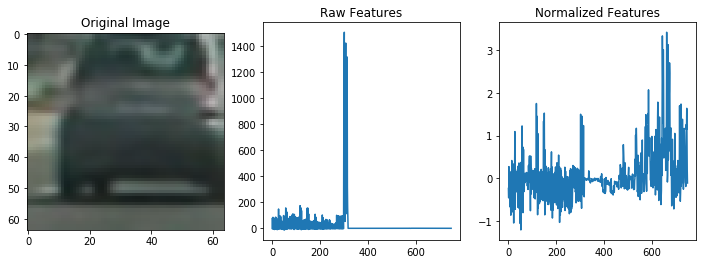

In [9]:
car_ind = 50
raw, normalizedFeatures = normalize_features(carFeatures,notCarFeatures, X_scaler)
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(carFiles[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(raw[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(normalizedFeatures[car_ind])
plt.title('Normalized Features')
plt.show()

In [10]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thickness=thick)
    # return the image copy with boxes drawn
    return draw_img
        
def add_heat(heatmap, bbox_list, weight=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += (1*weight)

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    # Return the image
    return img

In [11]:
def extract_features(image, Hogs=True):
    # Assure that all images are of the same size and type
    image = cv2.resize(image, (64, 64)).astype(np.float32)
    # Apply bin_spatial() to get spatial color features
    s_features = bin_spatial(image)
    # Apply color_hist() to get color histogram features
    hist_features = color_hist(image)
    if Hogs:
        # Get HOG features
        hog_features = hog_by_chan(image, rav=True)
        # Return feature vectors
        return np.concatenate((s_features, hist_features, hog_features))
    return np.concatenate((s_features, hist_features))


In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, decide, cells_per_step=5):
    # make a copy of the image
    img = img.astype(np.float32)
    boxes = []

    # Only searching relevant parts of the image
    imgToSearch = img[ystart:ystop, :, :]
    imshape = imgToSearch.shape

    # resize the image to the scale 1/n
    if scale != 1:
        imgToSearch = cv2.resize(imgToSearch, (np.int(
            imshape[1]/scale), np.int(imshape[0]/scale))).astype(np.float32)
        imshape = imgToSearch.shape

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    # how many blocks do we have per window
    nblocks_per_window = (window // PPC) - CPB + 1
    # blocks in the x axis
    nxblocks = (imgToSearch.shape[1] // PPC) - CPB + 1
    # blocks in the y axis
    nyblocks = (imgToSearch.shape[0] // PPC) - CPB + 1
    # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1 
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # windows = slide_window(imgToSearch,xy_overlap=(0.25, 0.25))

    # get the image hog features for the whole image
    hog_features_list = hog_by_chan(imgToSearch,rav=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            hog_feat_list = []
            # get our position in the image
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # define the coords to start and stop getting the image patch
            x_y = [xpos*PPC, ypos*PPC]
            x1_y1 = [xpos*PPC+window, ypos*PPC+window]
            # Extract the image patch
            subimg = cv2.resize(
                imgToSearch[x_y[1]:x1_y1[1], x_y[0]:x1_y1[0]], (64, 64))
            # get the HOG features from the image patch
            for hf in hog_features_list:
                hog_feat_list.append(
                    hf[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            hog_features = np.hstack(tuple(hog_feat_list))
            # Get color/spacial features
            s_and_hist_feats = extract_features(subimg, Hogs=False)
            # concatenate and transform features
            # Scale features
            test_features = X_scaler.transform(np.concatenate(
                (s_and_hist_feats, hog_features)).reshape(1, -1))
            # Make a prediction
            decision = svc.decision_function(test_features)
            # If the decision is above a threshold append to the output the resulting bounding box
            if decision > decide:
                xbox_left = np.int(x_y[0]*scale)
                ytop_draw = np.int(x_y[1]*scale)
                win_draw = np.int(64*scale)
                boxes.append([(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart)])
    return boxes

## Get a sample image and run the search on it
Take a look at what an image that had the features extracted from it, vehicles detected and bounding boxes drawn

0.2306356430053711 seconds


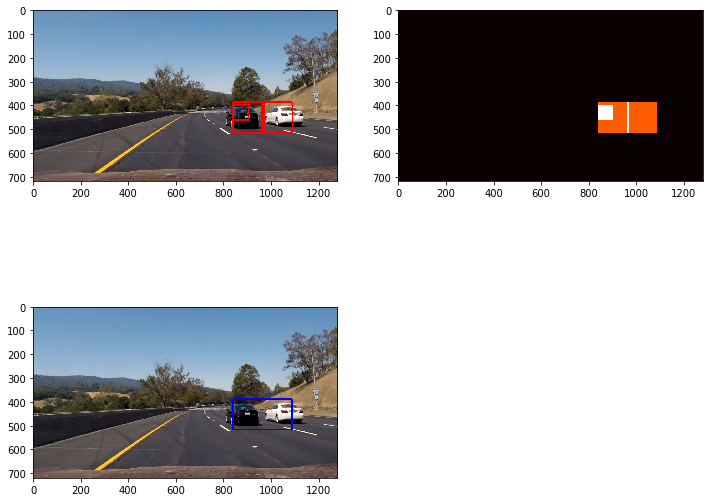

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy.ndimage.measurements import label
import time
# image = cv2.imread("test/start0.9.png")
# image = cv2.imread("test/mid22.0.png")
image = cv2.imread("test/close37.2.png")
carmap = []
t = time.time()
pete = [[400,464,1],[370, 500, 1.13],[390,600,2],[370,700,3]]
# pete = [[370,370+64*2,2],[370,370+64*3,1.75]]
for jane in pete:
    carmap.extend(find_cars(image, jane[0], jane[1], jane[2], 
                  clf, X_scaler, decide=1, cells_per_step=3))
draw_img = draw_boxes(np.copy(image), carmap)
heat = np.zeros_like(image[:,:,0]).astype(np.float32)
# Add heat to each box in box list
add_heat(heat,carmap)
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)

window_img = draw_labeled_bboxes(image, labels)    
print(time.time()-t, "seconds")
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))
plt.subplot(2,2,2)
plt.imshow(heatmap, cmap="hot")
plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
class vehicle_tracker:
    def __init__(self):
        self.n_frames = 10
        # Number of vehicles found
        self.nVehicles = 0
        # Heatmaps for vehicles
        self.vt_heatmap = []
        self.bboxes = deque(maxlen=self.n_frames)
        self.count = 0
        self.thresh = 1
    
    def determine_thresh(self):
        if self.count < self.n_frames:
            self.count += 1
            if self.count//3 == 0:
                return 1
            else:
                return self.count//3
        else:
            return self.n_frames//3
        
    
    def add_boxes(self,bboxes):
        self.bboxes.extend(bboxes)
        self.thresh = self.determine_thresh()
    
    
def detector(img, tracker, thresh=1, search_area=None, decide=0, cells_per_step=2):
    image = np.copy(img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    carmap = []
    if not search_area:
        search_area = [[370, 626, 1.5],[370,370+64*4,2]]
    for sa in search_area:
        carmap.extend(find_cars(image, sa[0], sa[1], sa[2],
                        clf, X_scaler, decide, cells_per_step=cells_per_step))
    tracker.add_boxes(carmap)
    heat = np.zeros_like(image[:, :, 0]).astype(np.float32)
    # Add heat to each box in box list
    # for b in tracker.boxes:
    add_heat(heat, tracker.bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, tracker.thresh*thresh)
    # Visualize the heatmap when displaying
    tracker.vt_heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label( tracker.vt_heatmap)
    tracker.nVehicles = labels[1]
    # Create a small heatmap image to put in the corner of the video
    hmap = np.zeros_like(image)
    hmap[:, :, 0] = tracker.vt_heatmap
    hmap[:, :, 1] = tracker.vt_heatmap
    hmap[:, :, 2] = tracker.vt_heatmap*(255//np.amax(tracker.vt_heatmap))
    wshp = image.shape
    smallhmap = cv2.resize(hmap, (np.int(wshp[1]/4), np.int(wshp[0]/4)))
    sshp = smallhmap.shape

    window_img = draw_labeled_bboxes(image,labels )
    window_img[0:sshp[0], wshp[1]-sshp[1]:wshp[1]] = smallhmap
    cv2.putText(window_img, 'Vehicles Detected: %i' % tracker.nVehicles,
                (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)

## Test the vehicle tracker across multiple frames

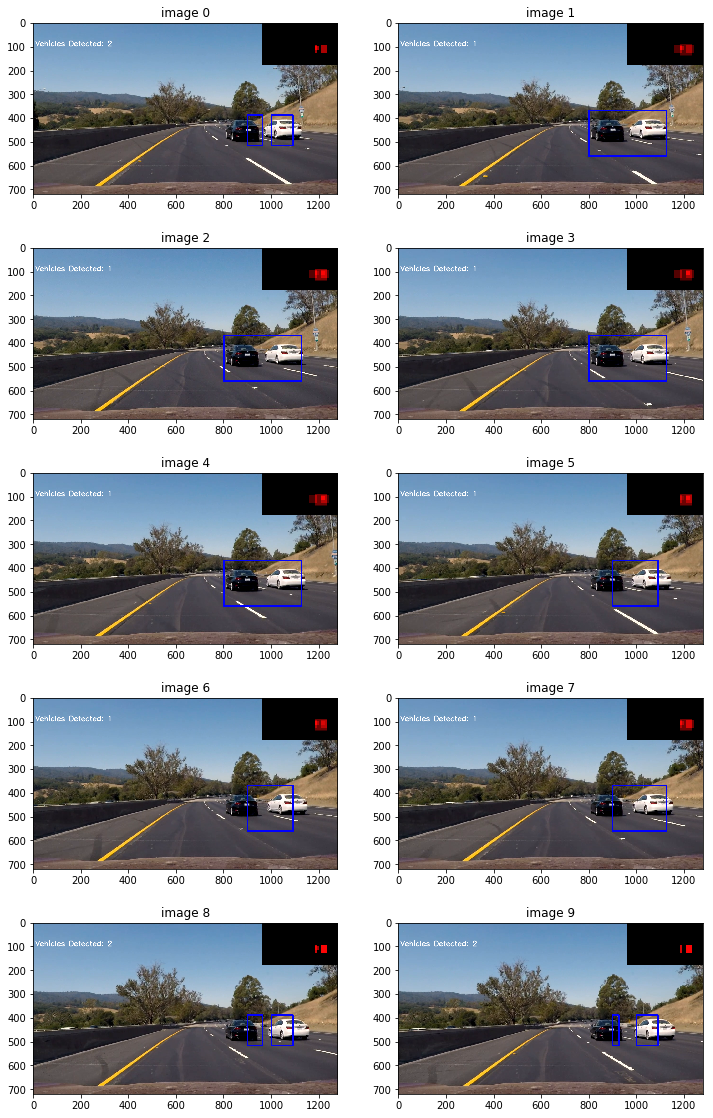

In [15]:
thresh = 1
decide = 0
search = [[400,464,1],[370, 500, 1.13],[390,600,2],[370,700,3]]
tracker = vehicle_tracker()
# test_img_files = retrieveImagePathList('test/mid*.png')
test_img_files = retrieveImagePathList('test/close*.png')
test_img = []
for file in test_img_files:
    test_img.append(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB))

imout = []
for img in test_img:
    imout.append(detector(img,  tracker, search_area=search, 
                thresh=thresh, decide=decide, cells_per_step=5))

plt.figure(figsize=(12, 20))
sp = 1
for d, i in enumerate(imout):
    plt.subplot(5,2, sp)
    plt.imshow(i)
    plt.title("image %i" % d)
    sp += 1
plt.show()